<img style="float: right;" src="images/Earthwave_logo.png" alt="earthwave" width="90"/> <img style="float: right;" src="images/UZH_logo.jpg" alt="uzh" width="200"/> <img style="float: right;" src="images/ESA_logo.png" alt="esa" width="150"/>


<img src="images/GlaMBIE_logo.png" alt="logo" width="400"/>

#<strong><font color='#11847C'> Gla</font>cier <font color='#11847C'>M</font>ass <font color='#11847C'>B</font>alance <font color='#11847C'>I</font>ntercomparison <font color='#11847C'>E</font>xercise - *A community effort to reconcile measurements of glacier mass balance*</strong>

##This Jupyter Notebook can be used to explore and visualise the final results from the Glacier Mass Balance Intercomparison Exercise (GlaMBIE). In the following code, you can choose from the 19 regions covered by the GlaMBIE project, and investigate the findings, including the mass change of the region.

<div>

## <strong>Getting started</strong>
</div>

First, we import the necessary packages

In [1]:
from google.cloud.storage import Client
import pandas as pd
import numpy as np
import glob, os
import matplotlib.pyplot as plt
from pathlib import Path

from helpers import glambie_regions_dropdown, derivative_to_cumulative, transform_string
from plotting import single_region_derivative_plot, single_region_cumulative_plot

import seaborn as sns
sns.set_theme(palette='muted', style='whitegrid', font_scale=1.2)

Next, we download the results of GlaMBIE from the WGMS server

In [2]:
# This section will be replaced once the data is hosted on WGMS server. The calls to the google bucket
# will be replaced with a simple download from wherever the files are hosted.
DATA_TRANSFER_BUCKET_NAME = "glambie-submissions"
PROJECT_NAME = "glambie"
storage_client = Client(project=PROJECT_NAME)

list_of_blobs_in_bucket = storage_client.list_blobs(DATA_TRANSFER_BUCKET_NAME)
downloaded_files = []

for blob in list_of_blobs_in_bucket:
    if 'glambie_csvs_to_publish_v2.zip' in blob.name:
        downloaded_files.append(blob.name)
        destination_file_path = os.path.join(blob.name)
        Path(destination_file_path).parent.mkdir(parents=True, exist_ok=True)
        with open(destination_file_path, "wb") as output_file:
            blob.download_to_file(output_file, raw_download=False)

Each of the results files is downloaded to the current Colab working environment.

<div>

## <strong>Choose a region</strong>
</div>

In this section, you can pick from the 19 RGI regions. The region that you chose will be read in from file.

In [2]:
# This line is only necessary when running locally. Once data is available online, it will be downloaded in 
# above cell to the local Colab working directory, so won't need to add local path to the start of 'data_directory' below
local_path = '/data/ox1/working/glambie/demo_notebooks'

In [3]:
temporal_option = 'hydrological_years'
data_directory = local_path + '/glambie_csvs_to_publish' + '/' + temporal_option

In [4]:
list_of_csvs = sorted(glob.glob(os.path.join(data_directory, '*.csv')))

In [5]:
# Use the dropdown menu to choose a region for analysis:
region = glambie_regions_dropdown()
region

Dropdown(description='Region:', options={'Alaska': 'alaska', 'Western Canada & US': 'western_canada_us', 'Arct…

In [6]:
for filename in list_of_csvs:
    if region.value in filename:
        region_dataframe = pd.read_csv(filename)

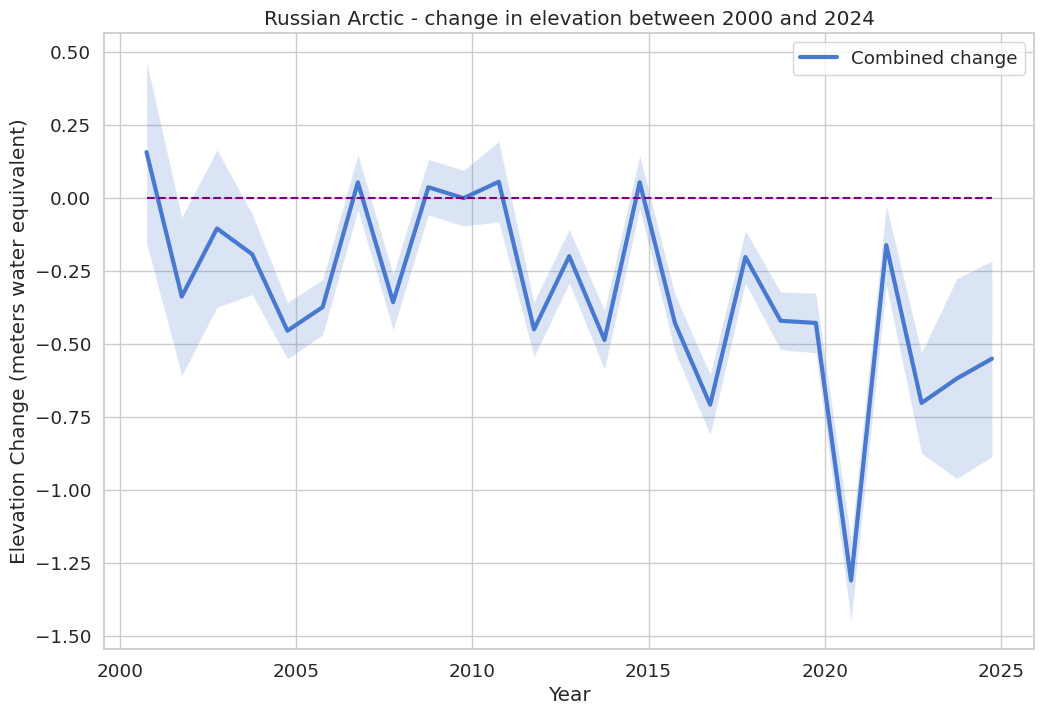

In [7]:
single_region_derivative_plot(region_dataframe, region.value)

<div>

## <strong>Plot ice loss for the reigon you have chosen</strong>
</div>

In [8]:
# Start with a simple cumulative mwe plot - explain that the following plot shows how many m of ice each region has lost over the last 24 years
cumulative_data_all_mwe = derivative_to_cumulative(region_dataframe.start_dates, region_dataframe.end_dates, region_dataframe.consensus_mwe)
cumulative_errors_all_mwe = derivative_to_cumulative(region_dataframe.start_dates, region_dataframe.end_dates, region_dataframe.consensus_mwe_errors, calculate_as_errors=True)

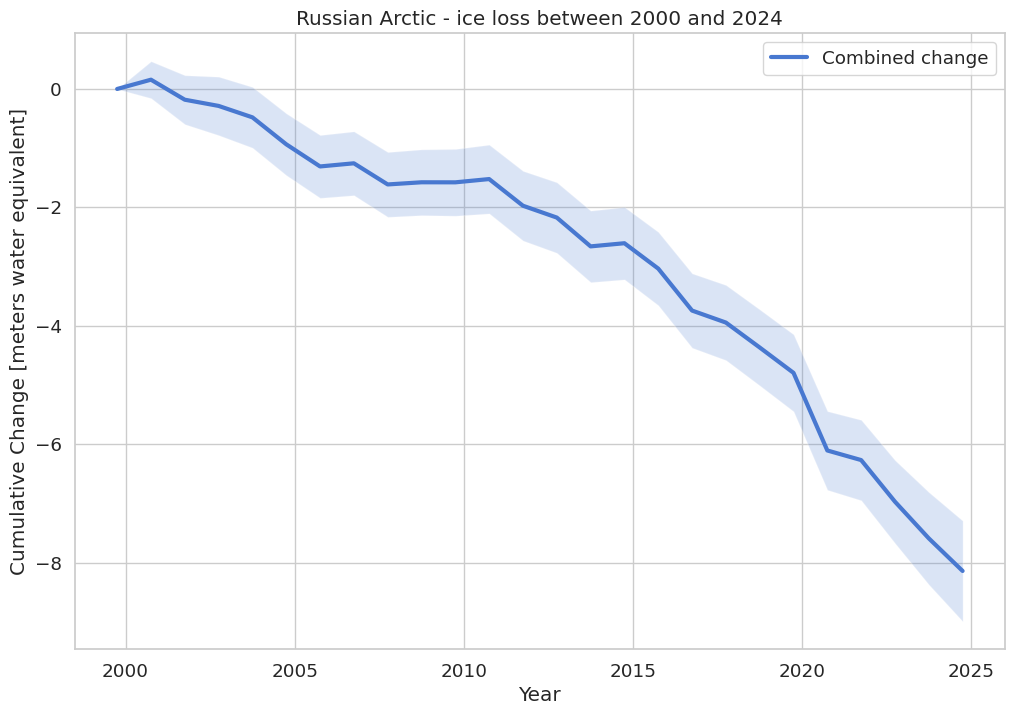

In [9]:
single_region_cumulative_plot(cumulative_data_all_mwe, cumulative_errors_all_mwe, region.value, 'meters water equivalent')

In [10]:
# convert to cumulative changes - Gt all
cumulative_data_all_gt = derivative_to_cumulative(region_dataframe.start_dates, region_dataframe.end_dates, region_dataframe.consensus_gt)
cumulative_errors_all_gt = derivative_to_cumulative(region_dataframe.start_dates, region_dataframe.end_dates, region_dataframe.consensus_gt_errors, calculate_as_errors=True)

In [11]:
cumulative_data_altimetry_gt = derivative_to_cumulative(region_dataframe.start_dates, region_dataframe.end_dates, region_dataframe.altimetry_gt)
cumulative_data_gravimetry_gt = derivative_to_cumulative(region_dataframe.start_dates, region_dataframe.end_dates, region_dataframe.gravimetry_gt)
cumulative_data_demdiff_and_glaciological_gt = derivative_to_cumulative(region_dataframe.start_dates, region_dataframe.end_dates, region_dataframe.demdiff_and_glaciological_gt)

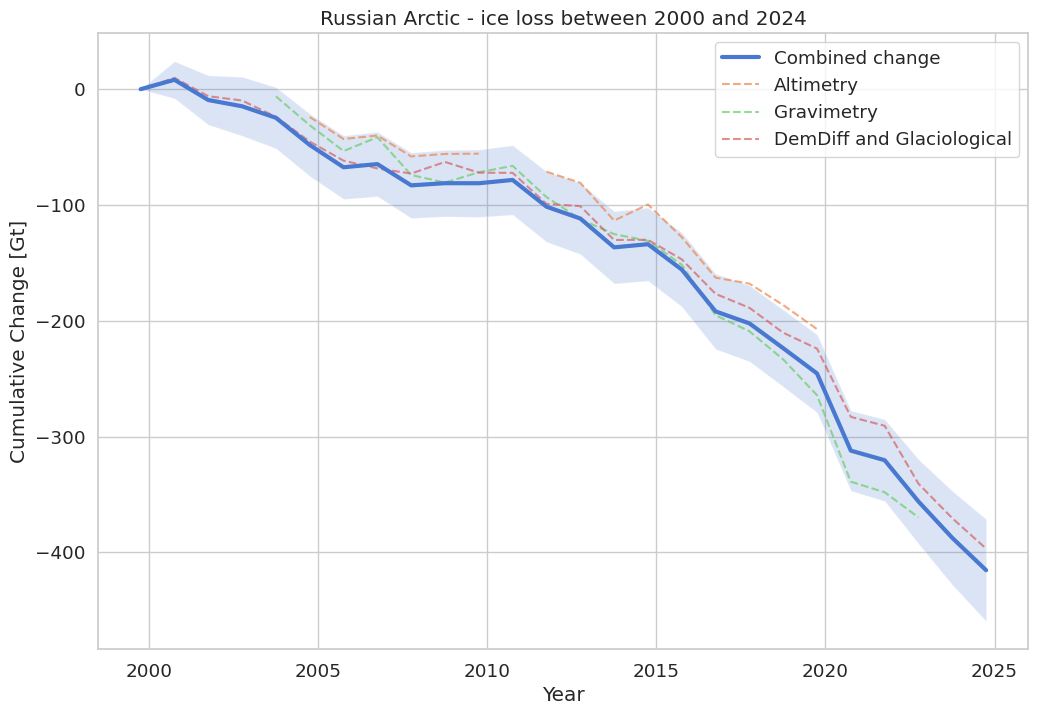

In [12]:
single_region_cumulative_plot(cumulative_data_all_gt, cumulative_errors_all_gt, region.value, 'Gt',
                                  cumulative_data_altimetry_gt, cumulative_data_gravimetry_gt, cumulative_data_demdiff_and_glaciological_gt)

In [13]:
comparison_region = glambie_regions_dropdown(region.value)
comparison_region

Dropdown(description='Region:', options={'Alaska': 'alaska', 'Western Canada & US': 'western_canada_us', 'Arct…

In [14]:
for filename in list_of_csvs:
    if comparison_region.value in filename:
        region_dataframe_comparison = pd.read_csv(filename)

In [15]:
cumulative_data_all_gt_comparison = derivative_to_cumulative(region_dataframe_comparison.start_dates, region_dataframe_comparison.end_dates, region_dataframe_comparison.consensus_gt)
cumulative_errors_all_gt_comparison = derivative_to_cumulative(region_dataframe_comparison.start_dates, region_dataframe_comparison.end_dates, region_dataframe_comparison.consensus_gt_errors, calculate_as_errors=True)

In [ ]:
plt.subplots(1, 1, figsize=(12,8))

plt.plot(cumulative_data_all_gt.dates, cumulative_data_all_gt.changes, linewidth=3, zorder=2, label='Consensus change - ' + transform_string(region.value))
plt.fill_between(cumulative_data_all_gt.dates, cumulative_data_all_gt.changes - cumulative_errors_all_gt.errors, cumulative_data_all_gt.changes + cumulative_errors_all_gt.errors, alpha=0.2)

plt.plot(cumulative_data_all_gt_comparison.dates, cumulative_data_all_gt_comparison.changes, linewidth=3, zorder=2, label='Consensus change - ' + transform_string(comparison_region.value))
plt.fill_between(cumulative_data_all_gt_comparison.dates, cumulative_data_all_gt_comparison.changes - cumulative_errors_all_gt_comparison.errors, cumulative_data_all_gt_comparison.changes + cumulative_errors_all_gt_comparison.errors, alpha=0.2)

plt.xlabel('Year')
plt.ylabel('Cumulative Change [Gt]')
plt.title('Regional comparison - Gt of ice loss between 2000 and 2024')

plt.legend(loc = 'lower left')